In [38]:
import sim_utils
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [39]:
def load_results(filename: str) -> [sim_utils.Trajectory]:
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [52]:
def postprocess(monte_carlo_results: [sim_utils.Trajectory]) -> dict:
    """
    Post-process Monte-Carlo simulation data to calculate relevant data
    
    Returns a dictionary
    """
    
    qf_vec = []
    hf_vec = []
    s_vec = []
    peakG_vec = []
    for traj in monte_carlo_results:
        X = traj.X
        params = traj.params
        u = traj.u
        
        h, s, v, gam = traj.X.T   # separate out the columns
        
        rho0 = params['rho0']
        beta = params['beta']
        H = params['H']
        LD = params['LD']
        
        rho = rho0 * np.exp(-h/H)
        q = rho * v * v / 2     # Dynamic pressure
        D_m = q / beta          # Drag Acceleration (D/m)

        L_m = LD * D_m * np.cos(u) # Lift Acceleration (L/m)
        G = np.sqrt(D_m ** 2 + L_m ** 2)/9.81
        peak_G = max(G)
        
        qf_vec.append(q[-1])       # Dynamic pressure at chute deploy
        hf_vec.append(h[-1])       # Altitude at chute deploy
        s_vec.append(s[-1])        # Downrange distance
        peakG_vec.append(peak_G)

    return {'qf': np.array(qf_vec),
            'hf': np.array(hf_vec),
            's': np.array(s_vec),
            'peak_G': np.array(peakG_vec),
           }

In [60]:
def plot_downrange_spread(filename):
    raw_data = load_results(filename)
    data = postprocess(raw_data)
    plt.hist(data['s']/1e3)
    plt.xlabel('Downrange distance [km]')
    plt.ylabel('Number of instances')
    plt.title(filename)
    plt.show()

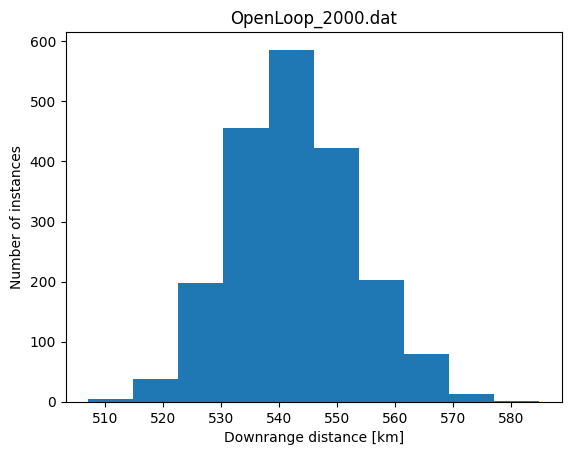

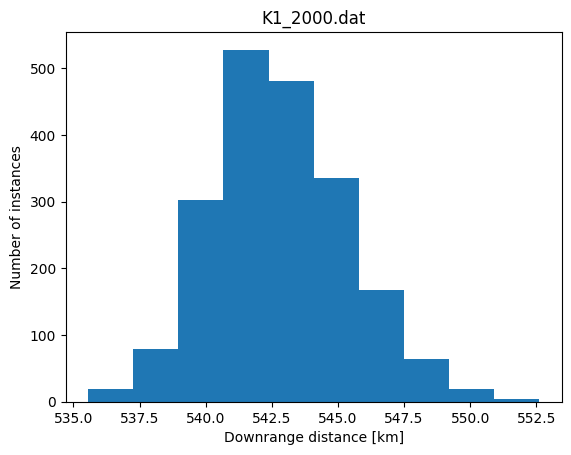

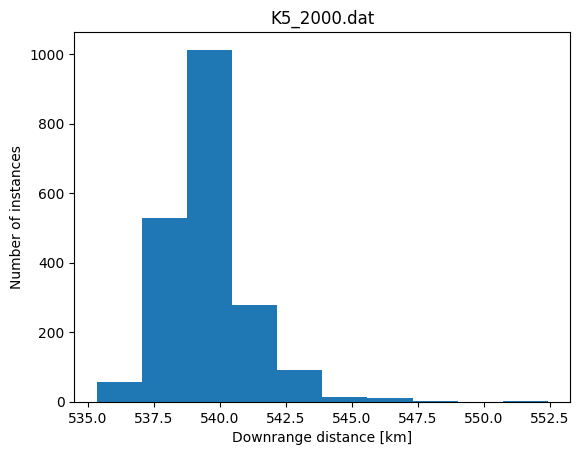

In [61]:
plot_downrange_spread('OpenLoop_2000.dat')
plot_downrange_spread('K1_2000.dat')
plot_downrange_spread('K5_2000.dat')